Refer to https://github.com/annisap/irs-mlp/blob/master/MLP-LearningCurves.ipynb

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [25]:
def data_import(df):
    import_df = pd.read_csv(f'../Data/wildfires_{df}.txt', sep='\t')
    
    for column in import_df:
        try:
            import_df[column] = import_df[column].str.strip()
        except:
            pass
        return import_df
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [26]:
df_train = pd.DataFrame(data_import('training'))
#df.reset_index(inplace=True, drop=False)
df_test = pd.DataFrame(data_import('test'))

index_val = df_train[df_train['rainfall']>= (df_train['rainfall'].mean()+(df_train['rainfall'].std()*6))].index
df_train.drop(index_val, inplace=True)




In [27]:
#X_cols = ['temp', 'humidity', 'rainfall', 'drought_code','buildup_index',  'wind_speed']
X_cols = ['drought_code', 'buildup_index', 'temp', 'humidity', 'rainfall']
y_col = ['fire']

X_train = df_train[X_cols]
y_train = df_train[y_col]

X_test = df_test[X_cols]
y_test = df_test[y_col]

In [28]:
#Encode Categorical variables with LabelEncoder
labelencoder = LabelEncoder()
df_train['fire'] = labelencoder.fit_transform(df_train["fire"])

fire = pd.DataFrame({'fire':['no', 'yes']})

In [29]:
"""
LabelEncoder introduced a new problem (noise) to our dataset: added numerical relationships in the features that now have become ordinal variables. 
That means that the model thinks that Iris-versicolor(1) is higher than Iris-setosa(0) and Iris-setosa(0) is smaller than Iris-virginica(2).
To solve that we would take a three dimensional vector, rather than an one dimensional vector with 3 values ([0,1,2])
"""
df_train = create_dummies(df_train, 'fire')

In [30]:
# Need to scale the data now - MLP(?) is sensitive to unnormalised data
unscaled_features = X_train

sc = StandardScaler()
#calculate μ & σ(fit) and apply the transformation(transform)
X_train_array = sc.fit_transform(X_train.values)
# Assign the scaled data to a DataFrame & use the index and columns arguments to keep your original indices and column names:
X_train = pd.DataFrame(X_train_array, index=X_train.index, columns=X_train.columns)
# Center test data with the μ & σ computed (fitted) on training data
X_test_array = sc.transform(X_test.values)
X_test = pd.DataFrame(X_test_array, index=X_test.index, columns=X_test.columns)

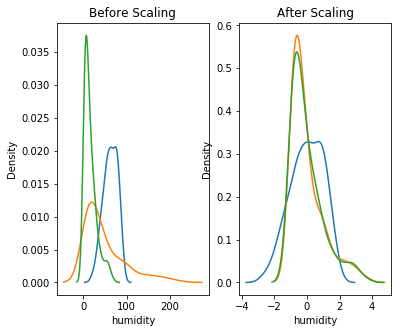

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(unscaled_features['humidity'], ax=ax1)
#sns.kdeplot(unscaled_features['rainfall'], ax=ax1)
sns.kdeplot(unscaled_features['drought_code'], ax=ax1)
sns.kdeplot(unscaled_features['buildup_index'], ax=ax1)
#sns.kdeplot(unscaled_features['wind_speed'], ax=ax1)

ax2.set_title('After Scaling')
sns.kdeplot(X_train['humidity'], ax=ax2)
#sns.kdeplot(X_train['rainfall'], ax=ax2)
sns.kdeplot(X_train['drought_code'], ax=ax2)
sns.kdeplot(X_train['buildup_index'], ax=ax2)
#sns.kdeplot(X_train['wind_speed'], ax=ax2)
plt.savefig("../Output/NN Variable Scaling.png")
plt.show()


In [32]:
mlp = MLPClassifier(hidden_layer_sizes=(10),activation='logistic' ,solver='sgd',learning_rate_init= 0.01, max_iter=500)

In [33]:
mlp.fit(X_train, y_train)

C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MLPClassifier(activation='logistic', hidden_layer_sizes=10,
              learning_rate_init=0.01, max_iter=500, solver='sgd')

In [34]:
mlp.score(X_test,y_test)

0.8

In [35]:
mlp.score(X_train, y_train)

0.8888888888888888

In [36]:
y_test_pred = mlp.predict(X_test)

# Model Evaluation

In [37]:
cross_val_score(mlp, X_test, y_test, cv=3, scoring='accuracy')

C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_

array([1.        , 0.82352941, 0.6875    ])

In [38]:
# Create predictions from the training data to build the confusion matrix
y_train_pred = cross_val_predict(mlp, X_train, y_train, cv=3)

C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\phil-\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

In [39]:
y_train_pred

array(['no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no',
       'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'y

In [40]:
confusion_matrix(y_test, y_test_pred)



array([[17,  5],
       [ 5, 23]], dtype=int64)

In [41]:
Y = y_test['fire'].map({'yes': 1, 'no': 0}).astype(int)
y_test_pred  = pd.Series(y_test_pred).map({'yes': 1, 'no': 0}).astype(int)

In [42]:
precision_score(Y, y_test_pred)


0.8214285714285714

In [43]:
recall_score(Y, y_test_pred)

0.8214285714285714

In [44]:
f1_score(Y, y_test_pred)

0.8214285714285714

In [45]:
# Test predictions vs actual observations 
confusion_matrix(Y, y_test_pred)


array([[17,  5],
       [ 5, 23]], dtype=int64)

In [46]:
len(y_train)

153

In [24]:
79/153

0.5163398692810458

In [ ]:
y_test_pred

In [ ]:
y_test_pred.sum()